# MTL782 Assignment 2 Track 3: Clustering-Based Action Clips Classification

Import all the necessary libraries:

In [ ]:
import tensorflow as tf

In [ ]:
import sonnet as snt

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import torchvision
from PIL import Image
from skimage.feature import hog
import os
from tqdm import tqdm
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.stats import f_oneway
%matplotlib inline

### Data Preprocessor Function:

In [27]:
def extract_frames(video_path, fps=1):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    interval = frame_rate // fps
    frames = []

    cnt = 0
    while True:
        ret, frame = cap.read()
        if ret == False:
            break
        if cnt % interval == 0:
            frame = cv2.resize(frame,(224,224))
            frames.append(frame)
        cnt += 1

    cap.release()
    return frames
            

## Functions for Feature Extraction:

### Optical Flow Features Extractor:
Uses Farneback method to compute optical flow between frames and return the mean and variance of motion magnitudes

In [29]:
def extract_optical_flow_features(frames):
    flow_magnitudes = []
    for i in range(len(frames) - 1):
        gray1 = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frames[i+1], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, pyr_scale=0.5, levels=3, winsize=15,iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
        magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        flow_magnitudes.append(magnitude)
        

    mean_flow = np.mean([np.mean(mag) for mag in flow_magnitudes])
    var_flow = np.mean([np.var(mag) for mag in flow_magnitudes])

    return mean_flow, var_flow

### HOG Features Extractor:
Computes HOG features on sampled keyframes (every 10th frame) and returns their average

In [30]:
def extract_hog_features(frames, keyframe_interval = 10):
    hog_features = []
    for idx, frame in enumerate(frames):
        if idx % keyframe_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            hog_features.append(features)
    return np.mean(hog_features, axis=0)

### ResNet50 Features Extractor:
Use ResNet50 (torchvision) to extract 2048D features from the last pooling layer per frame and returns their average

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def prepare_for_cnn(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame)
    return cnn_transform(pil_img).to(device)



model = torchvision.models.resnet50(pretrained=True)
model = model.to(device)
model.eval()

feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

def extract_resnet50_features(frames):
    features = []
    with torch.no_grad():
        for frame in frames:
            frame_tensor = prepare_for_cnn(frame).unsqueeze(0) 
            feat = feature_extractor(frame_tensor)
            feat = feat.view(-1).cpu().numpy()
            features.append(feat)
    return np.mean(features, axis=0)

### I3D Model:
Inception-v1 Inflated 3D ConvNet used for Kinetics CVPR paper.
The model is introduced in:
  Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
  Joao Carreira, Andrew Zisserman
  https://arxiv.org/pdf/1705.07750v1.pdf.

This code has been adapted from [https://github.com/google-deepmind/kinetics-i3d](http://github.com/google-deepmind/kinetics-i3d)

In [ ]:
"""Inception-v1 Inflated 3D ConvNet used for Kinetics CVPR paper.

The model is introduced in:

  Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
  Joao Carreira, Andrew Zisserman
  https://arxiv.org/pdf/1705.07750v1.pdf.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function




class Unit3D(snt.AbstractModule):
  """Basic unit containing Conv3D + BatchNorm + non-linearity."""

  def __init__(self, output_channels,
               kernel_shape=(1, 1, 1),
               stride=(1, 1, 1),
               activation_fn=tf.nn.relu,
               use_batch_norm=True,
               use_bias=False,
               name='unit_3d'):
    """Initializes Unit3D module."""
    super(Unit3D, self).__init__(name=name)
    self._output_channels = output_channels
    self._kernel_shape = kernel_shape
    self._stride = stride
    self._use_batch_norm = use_batch_norm
    self._activation_fn = activation_fn
    self._use_bias = use_bias

  def _build(self, inputs, is_training):
    """Connects the module to inputs.

    Args:
      inputs: Inputs to the Unit3D component.
      is_training: whether to use training mode for snt.BatchNorm (boolean).

    Returns:
      Outputs from the module.
    """
    net = snt.Conv3D(output_channels=self._output_channels,
                     kernel_shape=self._kernel_shape,
                     stride=self._stride,
                     padding=snt.SAME,
                     use_bias=self._use_bias)(inputs)
    if self._use_batch_norm:
      bn = snt.BatchNorm()
      net = bn(net, is_training=is_training, test_local_stats=False)
    if self._activation_fn is not None:
      net = self._activation_fn(net)
    return net


class InceptionI3d(snt.AbstractModule):
  """Inception-v1 I3D architecture.

  The model is introduced in:

    Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
    Joao Carreira, Andrew Zisserman
    https://arxiv.org/pdf/1705.07750v1.pdf.

  See also the Inception architecture, introduced in:

    Going deeper with convolutions
    Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
    Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.
    http://arxiv.org/pdf/1409.4842v1.pdf.
  """

  # Endpoints of the model in order. During construction, all the endpoints up
  # to a designated `final_endpoint` are returned in a dictionary as the
  # second return value.
  VALID_ENDPOINTS = (
      'Conv3d_1a_7x7',
      'MaxPool3d_2a_3x3',
      'Conv3d_2b_1x1',
      'Conv3d_2c_3x3',
      'MaxPool3d_3a_3x3',
      'Mixed_3b',
      'Mixed_3c',
      'MaxPool3d_4a_3x3',
      'Mixed_4b',
      'Mixed_4c',
      'Mixed_4d',
      'Mixed_4e',
      'Mixed_4f',
      'MaxPool3d_5a_2x2',
      'Mixed_5b',
      'Mixed_5c',
      'Logits',
      'Predictions',
  )

  def __init__(self, num_classes=400, spatial_squeeze=True,
               final_endpoint='Logits', name='inception_i3d'):
    """Initializes I3D model instance.

    Args:
      num_classes: The number of outputs in the logit layer (default 400, which
          matches the Kinetics dataset).
      spatial_squeeze: Whether to squeeze the spatial dimensions for the logits
          before returning (default True).
      final_endpoint: The model contains many possible endpoints.
          `final_endpoint` specifies the last endpoint for the model to be built
          up to. In addition to the output at `final_endpoint`, all the outputs
          at endpoints up to `final_endpoint` will also be returned, in a
          dictionary. `final_endpoint` must be one of
          InceptionI3d.VALID_ENDPOINTS (default 'Logits').
      name: A string (optional). The name of this module.

    Raises:
      ValueError: if `final_endpoint` is not recognized.
    """

    if final_endpoint not in self.VALID_ENDPOINTS:
      raise ValueError('Unknown final endpoint %s' % final_endpoint)

    super(InceptionI3d, self).__init__(name=name)
    self._num_classes = num_classes
    self._spatial_squeeze = spatial_squeeze
    self._final_endpoint = final_endpoint

  def _build(self, inputs, is_training, dropout_keep_prob=1.0):
    """Connects the model to inputs.

    Args:
      inputs: Inputs to the model, which should have dimensions
          `batch_size` x `num_frames` x 224 x 224 x `num_channels`.
      is_training: whether to use training mode for snt.BatchNorm (boolean).
      dropout_keep_prob: Probability for the tf.nn.dropout layer (float in
          [0, 1)).

    Returns:
      A tuple consisting of:
        1. Network output at location `self._final_endpoint`.
        2. Dictionary containing all endpoints up to `self._final_endpoint`,
           indexed by endpoint name.

    Raises:
      ValueError: if `self._final_endpoint` is not recognized.
    """
    if self._final_endpoint not in self.VALID_ENDPOINTS:
      raise ValueError('Unknown final endpoint %s' % self._final_endpoint)

    net = inputs
    end_points = {}
    end_point = 'Conv3d_1a_7x7'
    net = Unit3D(output_channels=64, kernel_shape=[7, 7, 7],
                 stride=[2, 2, 2], name=end_point)(net, is_training=is_training)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points
    end_point = 'MaxPool3d_2a_3x3'
    net = tf.nn.max_pool3d(net, ksize=[1, 1, 3, 3, 1], strides=[1, 1, 2, 2, 1],
                           padding=snt.SAME, name=end_point)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points
    end_point = 'Conv3d_2b_1x1'
    net = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                 name=end_point)(net, is_training=is_training)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points
    end_point = 'Conv3d_2c_3x3'
    net = Unit3D(output_channels=192, kernel_shape=[3, 3, 3],
                 name=end_point)(net, is_training=is_training)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points
    end_point = 'MaxPool3d_3a_3x3'
    net = tf.nn.max_pool3d(net, ksize=[1, 1, 3, 3, 1], strides=[1, 1, 2, 2, 1],
                           padding=snt.SAME, name=end_point)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_3b'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=96, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=128, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=16, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=32, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)

      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_3c'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=192, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=96, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'MaxPool3d_4a_3x3'
    net = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1], strides=[1, 2, 2, 2, 1],
                           padding=snt.SAME, name=end_point)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4b'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=192, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=96, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=208, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=16, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=48, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4c'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=160, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=112, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=224, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=24, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=64, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4d'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=256, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=24, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=64, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4e'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=112, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=144, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=288, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=64, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=64, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_4f'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=256, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=160, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=320, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=128, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'MaxPool3d_5a_2x2'
    net = tf.nn.max_pool3d(net, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1],
                           padding=snt.SAME, name=end_point)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_5b'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=256, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=160, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=320, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=32, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=128, kernel_shape=[3, 3, 3],
                          name='Conv3d_0a_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Mixed_5c'
    with tf.variable_scope(end_point):
      with tf.variable_scope('Branch_0'):
        branch_0 = Unit3D(output_channels=384, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
      with tf.variable_scope('Branch_1'):
        branch_1 = Unit3D(output_channels=192, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_1 = Unit3D(output_channels=384, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_1,
                                                is_training=is_training)
      with tf.variable_scope('Branch_2'):
        branch_2 = Unit3D(output_channels=48, kernel_shape=[1, 1, 1],
                          name='Conv3d_0a_1x1')(net, is_training=is_training)
        branch_2 = Unit3D(output_channels=128, kernel_shape=[3, 3, 3],
                          name='Conv3d_0b_3x3')(branch_2,
                                                is_training=is_training)
      with tf.variable_scope('Branch_3'):
        branch_3 = tf.nn.max_pool3d(net, ksize=[1, 3, 3, 3, 1],
                                    strides=[1, 1, 1, 1, 1], padding=snt.SAME,
                                    name='MaxPool3d_0a_3x3')
        branch_3 = Unit3D(output_channels=128, kernel_shape=[1, 1, 1],
                          name='Conv3d_0b_1x1')(branch_3,
                                                is_training=is_training)
      net = tf.concat([branch_0, branch_1, branch_2, branch_3], 4)
    end_points[end_point] = net
    if self._final_endpoint == end_point: return net, end_points

    end_point = 'Logits'
    with tf.variable_scope(end_point):
      net = tf.nn.avg_pool3d(net, ksize=[1, 2, 7, 7, 1],
                             strides=[1, 1, 1, 1, 1], padding=snt.VALID)
      net = tf.nn.dropout(net, dropout_keep_prob)
      logits = Unit3D(output_channels=self._num_classes,
                      kernel_shape=[1, 1, 1],
                      activation_fn=None,
                      use_batch_norm=False,
                      use_bias=True,
                      name='Conv3d_0c_1x1')(net, is_training=is_training)
      if self._spatial_squeeze:
        logits = tf.squeeze(logits, [2, 3], name='SpatialSqueeze')
    averaged_logits = tf.reduce_mean(logits, axis=1)
    end_points[end_point] = averaged_logits
    if self._final_endpoint == end_point: return averaged_logits, end_points

    end_point = 'Predictions'
    predictions = tf.nn.softmax(averaged_logits)
    end_points[end_point] = predictions
    return predictions, end_points

### I3D Feature Extractor:
Extracts features from the logits layer of the Inception I3D Model. Unlike other feature extractors, this one takes in the video without preprocessing as it performs its own preprocessing in accordance with what is required by the I3D model.

In [ ]:
# Constants matching the original sample script
_IMAGE_SIZE = 224
_SAMPLE_VIDEO_FRAMES = 79
_CHECKPOINT_PATHS = {
    'rgb600': 'rgb_scratch_kin600/model.ckpt',
}

def load_video_rgb(path, num_frames=_SAMPLE_VIDEO_FRAMES, size=_IMAGE_SIZE):
    """
    Load a video from disk, sample (or pad) to num_frames, resize frames to size x size,
    and return a numpy array of shape (1, num_frames, size, size, 3), dtype=float32.
    
    Frames are extracted at a rate of min(video_fps, 25) fps.
    """
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video {path}")
    
    # 1) Get native FPS and total frame count
    native_fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    
    # 2) Determine sample rate (fps) and compute step
    sample_fps = min(native_fps, 25.0) if native_fps > 0 else 25.0
    # How many original frames between each sampled frame
    step = native_fps / sample_fps if native_fps > 0 else 1.0
    
    frames = []
    next_capture = 0.0  # next frame index threshold to capture
    
    # 3) Iterate through video, capturing at the right moments
    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        
        if len(frames) < num_frames and i >= next_capture:
            # BGR to RGB, resize, normalize
            frm = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frm = cv2.resize(frm, (size, size))
            frames.append(frm.astype(np.float32) / 255.0)
            
            # schedule next capture
            next_capture += step
    
    cap.release()
    
    # 4) If we didn’t get enough frames (e.g. very short video), pad by repeating last
    if not frames:
        # avoid empty; create a black frame
        black = np.zeros((size, size, 3), dtype=np.float32)
        frames = [black] * num_frames
    else:
        while len(frames) < num_frames:
            frames.append(frames[-1].copy())
    
    # 5) Stack and add batch dimension
    video_array = np.stack(frames, axis=0)            # (num_frames, H, W, 3)
    return np.expand_dims(video_array, axis=0)        # (1, num_frames, H, W, 3)


def extract_i3d_features(video_path,
                             checkpoint_path=_CHECKPOINT_PATHS['rgb600'],
                             num_classes=600,
                             num_frames=_SAMPLE_VIDEO_FRAMES,
                             image_size=_IMAGE_SIZE,
                             endpoint='Predictions'):
    """
    Loads a video, runs the I3D rgb600 model up to `endpoint`, and returns
    the activations at that layer as a numpy array.
    
    Returns:
      features: np.ndarray of shape (1, t, h, w, c) where t/h/w/c depend on endpoint.
    """
    tf.reset_default_graph()
    
    # Placeholder and model instantiation
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, num_frames, image_size, image_size, 3),
        name='rgb_input')
    with tf.variable_scope('RGB'):
        rgb_model = InceptionI3d(
            num_classes, spatial_squeeze=False, final_endpoint=endpoint)
        feat_tensor, end_points = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    
    # Build variable map & saver
    rgb_variable_map = {}
    for var in tf.global_variables():
        if var.name.split('/')[0] == 'RGB':
            # strip the leading scope so names match checkpoint
            name_in_ckpt = var.name.replace(':0', '')[len('RGB/inception_i3d/'):]
            rgb_variable_map[name_in_ckpt] = var
    saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
    
    # Load video and run
    video_np = load_video_rgb(video_path, num_frames, image_size)
    with tf.Session() as sess:
        saver.restore(sess, checkpoint_path)
        features = sess.run(end_points[endpoint],
                            feed_dict={rgb_input: video_np})
    # print("here")
    return np.squeeze(features)

# Example usage:
# feats = extract_logits_features('train_set/train_set/v_BaseballPitch_g03_c01.avi')
# print(feats.shape)


### MBH Feature Extractor:
Extracts Motion Boundary Histogram Features

In [ ]:
def compute_optical_flow(frames):
    flows = []
    prev = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    for frame in frames[1:]:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        flow = cv2.calcOpticalFlowFarneback(
            prev, frame, None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2, flags=0
        )
        flows.append(flow)
        prev = frame
    return flows

def compute_mbh(flows, cell_size=8, bin_size=45, block_size=2):
    num_bins = int(360 // bin_size)
    features = []
    
    for flow in flows:
        Vx, Vy = flow[..., 0], flow[..., 1]
        
        grad_x_Vx = cv2.Sobel(Vx, cv2.CV_64F, 1, 0, ksize=3)
        grad_y_Vx = cv2.Sobel(Vx, cv2.CV_64F, 0, 1, ksize=3)
        grad_x_Vy = cv2.Sobel(Vy, cv2.CV_64F, 1, 0, ksize=3)
        grad_y_Vy = cv2.Sobel(Vy, cv2.CV_64F, 0, 1, ksize=3)
        
        mbhx_mag = np.sqrt(grad_x_Vx**2 + grad_y_Vx**2)
        mbhx_ang = np.arctan2(grad_y_Vx, grad_x_Vx) * (180/np.pi) % 360
        
        mbhy_mag = np.sqrt(grad_x_Vy**2 + grad_y_Vy**2)
        mbhy_ang = np.arctan2(grad_y_Vy, grad_x_Vy) * (180/np.pi) % 360
        
        mbhx_feat = _compute_histograms(mbhx_mag, mbhx_ang, cell_size, num_bins, block_size)
        mbhy_feat = _compute_histograms(mbhy_mag, mbhy_ang, cell_size, num_bins, block_size)
        
        features.append(np.concatenate([mbhx_feat, mbhy_feat]))
    
    return np.array(features)

def _compute_histograms(magnitude, orientation, cell_size, num_bins, block_size):
    h, w = magnitude.shape
    cell_grid = (h//cell_size, w//cell_size)
    
    hist = np.zeros((cell_grid[0], cell_grid[1], num_bins))
    
    for i in range(cell_grid[0]):
        for j in range(cell_grid[1]):
            # Extract cell
            y_slice = slice(i*cell_size, (i+1)*cell_size)
            x_slice = slice(j*cell_size, (j+1)*cell_size)
            
            cell_mag = magnitude[y_slice, x_slice]
            cell_ang = orientation[y_slice, x_slice]
            
            bin_idx = np.floor(cell_ang / (360/num_bins)).astype(int) % num_bins
            
            for b in range(num_bins):
                hist[i, j, b] = np.sum(cell_mag[bin_idx == b])
    
    normalized = []
    for i in range(cell_grid[0] - block_size + 1):
        for j in range(cell_grid[1] - block_size + 1):
            block = hist[i:i+block_size, j:j+block_size, :]
            norm = np.linalg.norm(block)
            if norm > 0:
                block = block / norm
            normalized.append(block.flatten())
    
    return np.concatenate(normalized)

def extract_mbh_features(frames):    
    flows = compute_optical_flow(frames)
    mbh_features = compute_mbh(flows)
    
    return mbh_features


### Loading the Dataset:

In [ ]:
video_dir = "train_set/train_set"
video_files = [os.path.join(video_dir,f) for f in os.listdir(video_dir) if f.endswith('.avi')]

## Preprocessing and Feature Extraction:

### I3D Feature Extraction:
Did not do Normalization as I3D already returns softmaxed features

In [ ]:
i3d_data = []

for video_path in tqdm(video_files):
    video_id = os.path.basename(video_path)
    
    i3d_feats = extract_i3d_features(video_path = video_path)
    row = {"video_id": video_id}
    for i, feat in enumerate(i3d_feats):
        row[f"feature_{i+1}"] = feat
    
    i3d_data.append(row)

df_i3d = pd.DataFrame(i3d_data).set_index("video_id")
df_i3d.to_csv("FeaturesNC/i3d_features.csv")

### Optical Flow Feature Extraction:
Did not do normalization as magnitude carries information like speed of action

In [ ]:
optical_flow_data = []

for video_path in tqdm(video_files, leave=False):
    video_id = os.path.basename(video_path)
    frames = extract_frames(video_path, fps=25)

    optical_flow_feats = extract_optical_flow_features(frames)

    row = {"video_id": video_id}
    for i, feat in enumerate(optical_flow_feats):
        row[f"feature_{i+1}"] = feat
    
    optical_flow_data.append(row)

df_optical_flow = pd.DataFrame(optical_flow_data).set_index("video_id")
df_optical_flow.to_csv("FeaturesNC/optical_flow_features.csv")

### HOG Feature Extraction:
Did not do normalization as HOG has it built in normalization

In [ ]:
hog_data = []

for video_path in tqdm(video_files):
    video_id = os.path.basename(video_path)
    frames = extract_frames(video_path, fps=25)

    hog_feats = extract_hog_features(frames)
    
    row = {"video_id": video_id}
    for i, feat in enumerate(hog_feats):
        row[f"feature_{i+1}"] = feat
    
    hog_data.append(row)

df_hog = pd.DataFrame(hog_data).set_index("video_id")
df_hog.to_csv("FeaturesNC/hog_features.csv")

### ResNet50 Feature Extraction and Normalization:
First standardized the features, then applied L-2 normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
resnet50_data = []


for video_path in video_files:
    video_id = os.path.basename(video_path)
    frames = extract_frames(video_path, fps=25)

    resnet50_feats = extract_resnet50_features(frames)
    row = {"video_id": video_id}
    for i, feat in enumerate(resnet50_feats):
        row[f"feature_{i+1}"] = feat
    
    resnet50_data.append(row)

df_resnet50 = pd.DataFrame(resnet50_data).set_index("video_id")

scaler = StandardScaler()
feats_std = scaler.fit_transform(df_resnet50.values)
df_std = pd.DataFrame(feats_std, index=df_resnet50.index, columns=df_resnet50.columns)

feats_normed = normalize(df_std.values, norm='l2', axis=1)
df_normed = pd.DataFrame(feats_normed, index=df_std.index, columns=df_std.columns)

df_normed.to_csv("FeaturesNC/resnet50_features_standardized_l2.csv")

### MBH Feature Extraction and Normalization:
Used rootsift normalization

In [ ]:
mbh_data = []

for video_path in tqdm(video_files):
    video_id = os.path.basename(video_path)
    frames = extract_frames(video_path, fps=1)
    
    mbh_feats = extract_mbh_features(frames)
    
    if len(mbh_feats) == 0:
        print(f"Warning: No MBH features for {video_id}")
        continue
    
    avg_feature = np.mean(mbh_feats, axis=0)

    row = {"video_id": video_id}

    for i, feat in enumerate(avg_feature):
        row[f"feature_{i+1}"] = feat
    
    mbh_data.append(row)

df_mbh = pd.DataFrame(mbh_data).set_index("video_id")
df_l1_norm = df_mbh.div(df_mbh.abs().sum(axis=1), axis=0)
df_mbh = pd.DataFrame(mbh_data).set_index("video_id")
df_l1_norm = df_mbh.div(df_mbh.abs().sum(axis=1), axis=0)
df_rootsift = np.sqrt(df_l1_norm)
df_rootsift.to_csv("FeaturesNC/mbh_features_rootsift.csv")

### Combining all Features together:

In [ ]:
df_optical_flow = pd.read_csv("FeaturesNC/optical_flow_features.csv")
df_hog = pd.read_csv("FeaturesNC/hog_features.csv")
df_resnet50 = pd.read_csv("FeaturesNC/resnet50_features_standardized_l2.csv")
df_i3d = pd.read_csv("FeaturesNC/i3d_features.csv")
df_mbh = pd.read_csv("FeaturesNC/mbh_features_rootsift.csv")

In [80]:
dfs = [df_optical_flow, df_hog, df_resnet50, df_i3d, df_mbh]
feature_types = ['of', 'hog', 'resnet', 'i3d', 'mbh'] 

for i, df in enumerate(dfs):
    new_columns = ['video_id'] + [f'{feature_types[i]}_{col}' 
                                 for col in df.columns if col != 'video_id']
    dfs[i].columns = new_columns

df_complete = dfs[0]
for i in tqdm(range(len(dfs) - 1)):
    df_complete = df_complete.merge(dfs[i+1], on="video_id", how='inner') 
    
df_complete.to_csv("FeaturesNC.csv")

Code to create Dataframe without MBH feature (used later on):

In [ ]:
dfs = [df_optical_flow, df_hog, df_resnet50, df_i3d, 
       # df_mbh
      ]

feature_types = ['of', 'hog', 'resnet', 'i3d', # 'mbh'
                ]  
for i, df in enumerate(dfs):
    new_columns = ['video_id'] + [f'{feature_types[i]}_{col}' 
                                 for col in df.columns if col != 'video_id']
    dfs[i].columns = new_columns

df_2 = dfs[0]
for i in tqdm(range(len(dfs) - 1)):
    df_2 = df_complete.merge(dfs[i+1], on="video_id", how='inner') 
    


## Exploratory Data Analysis:

### Optical Flow Maps:
We plotted Optical Flow Maps for a random video from each action

Baseball Pitch:

Processing complete! Video saved to: /kaggle/working/BaseballPitch.avi


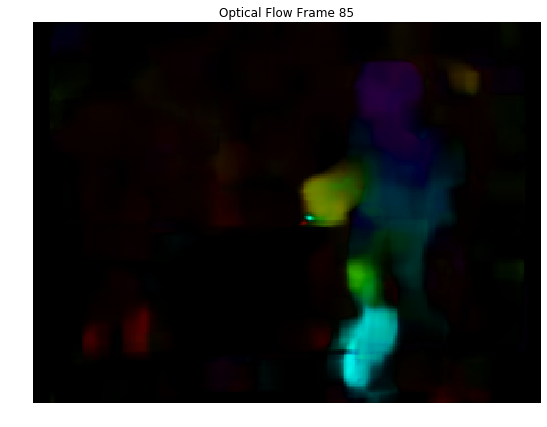

In [ ]:
input_path = 'train_set/train_set/v_BaseballPitch_g03_c01.avi'  # Update with your video path
output_path = 'BaseballPitch.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Bench Press

Processing complete! Video saved to: /kaggle/working/BenchPress.avi


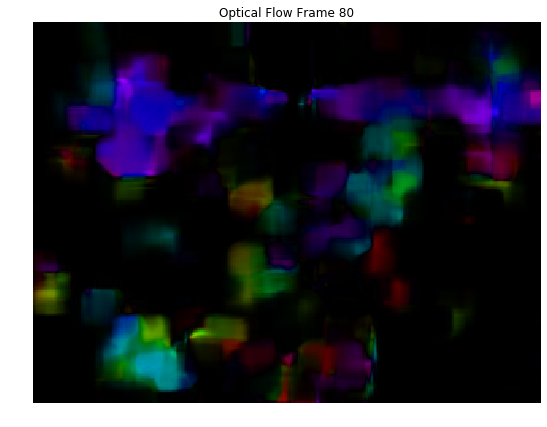

In [ ]:
input_path = 'train_set/train_set/v_BenchPress_g02_c01.avi'  # Update with your video path
output_path = 'BenchPress.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  # Try 'XVID' if DIVX fails
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  # Show every 5th frame (adjust as needed)

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    out.write(flow_bgr)
    
    # Display in notebook
    frame_count += 1
    if frame_count % display_interval == 0:
        # Convert BGR to RGB for matplotlib
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  # Clear previous output
    
    prev_gray = next_gray

# Cleanup
cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Billiards

Processing complete! Video saved to: /kaggle/working/Billards.avi


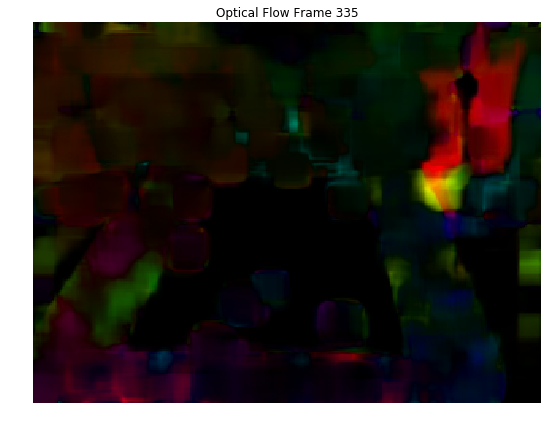

In [ ]:
input_path = 'train_set/train_set/v_Billards_g02_c01.avi'  # Update with your video path
output_path = 'Billards.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Diving

Processing complete! Video saved to: /kaggle/working/Diving.avi


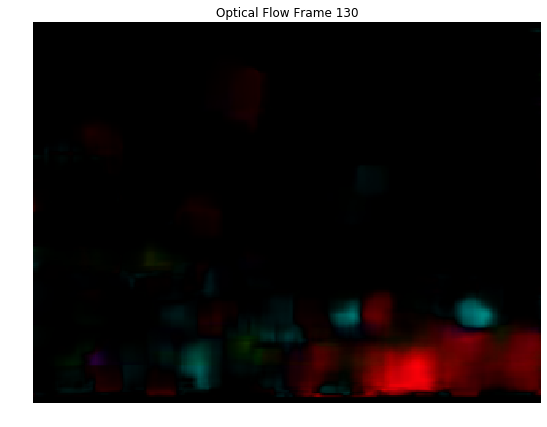

In [ ]:
input_path = 'train_set/train_set/v_Diving_g02_c01.avi'  # Update with your video path
output_path = 'Diving.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Drumming:

Processing complete! Video saved to: /kaggle/working/Drumming.avi


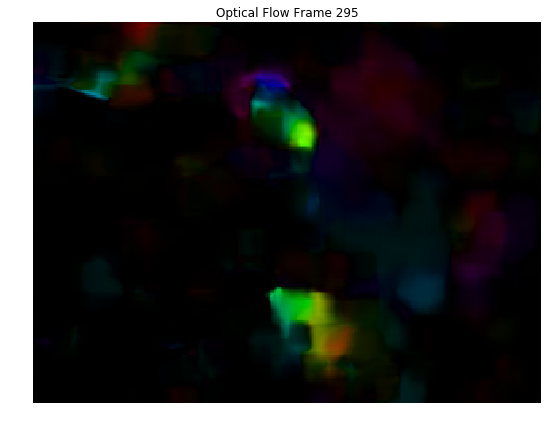

In [ ]:
input_path = 'train_set/train_set/v_Drumming_g02_c01.avi'  # Update with your video path
output_path = 'Drumming.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Horse Riding:

Processing complete! Video saved to: /kaggle/working/HorseRiding.avi


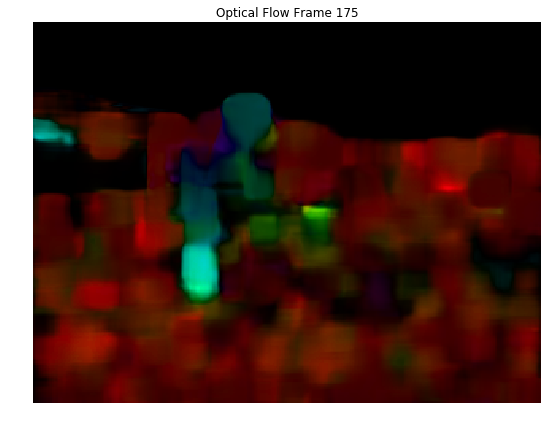

In [ ]:
input_path = 'train_set/train_set/v_HorseRiding_g02_c01.avi'  # Update with your video path
output_path = 'HorseRiding.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Jump Rope:

Processing complete! Video saved to: /kaggle/working/JumpRope.avi


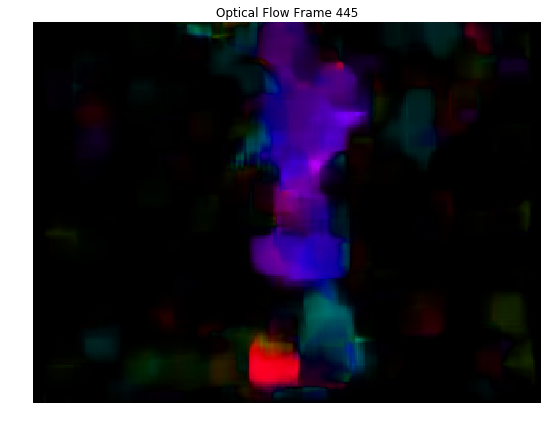

In [ ]:
input_path = 'train_set/train_set/v_JumpRope_g02_c01.avi'  # Update with your video path
output_path = 'JumpRope.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Kayaking:

Processing complete! Video saved to: /kaggle/working/Kayaking.avi


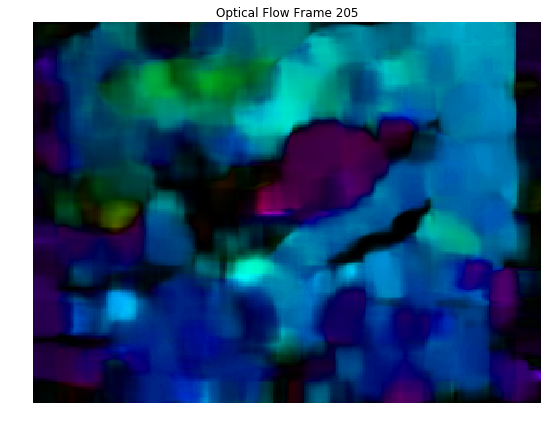

In [ ]:
input_path = 'train_set/train_set/v_Kayaking_g04_c01.avi'  # Update with your video path
output_path = 'Kayaking.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Mixing:

Processing complete! Video saved to: /kaggle/working/Mixing.avi


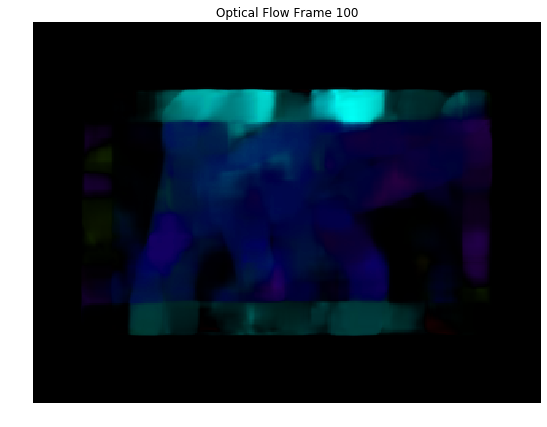

In [ ]:
input_path = 'train_set/train_set/v_Mixing_g01_c01.avi'  # Update with your video path
output_path = 'Mixing.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Playing Guitar:

Processing complete! Video saved to: /kaggle/working/PlayingGuitar.avi


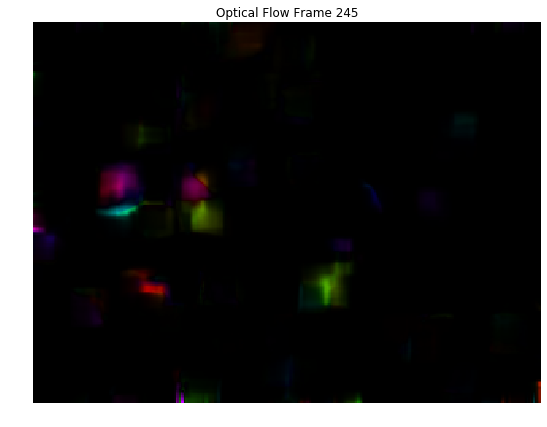

In [ ]:
input_path = 'train_set/train_set/v_PlayingGuitar_g03_c01.avi'  # Update with your video path
output_path = 'PlayingGuitar.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Pole Vault:

Processing complete! Video saved to: /kaggle/working/PoleVault.avi


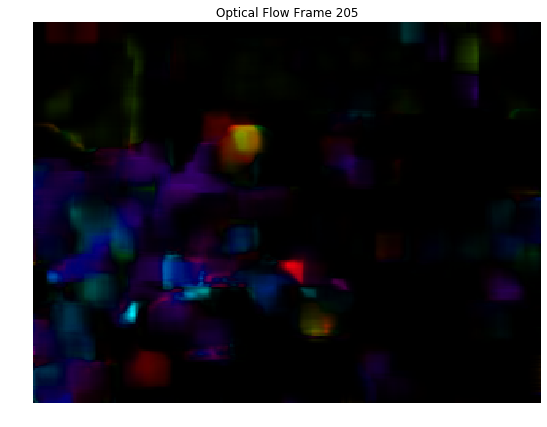

In [ ]:
input_path = 'train_set/train_set/v_PoleVault_g04_c01.avi'  # Update with your video path
output_path = 'PoleVault.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Punch:

Processing complete! Video saved to: /kaggle/working/Punch.avi


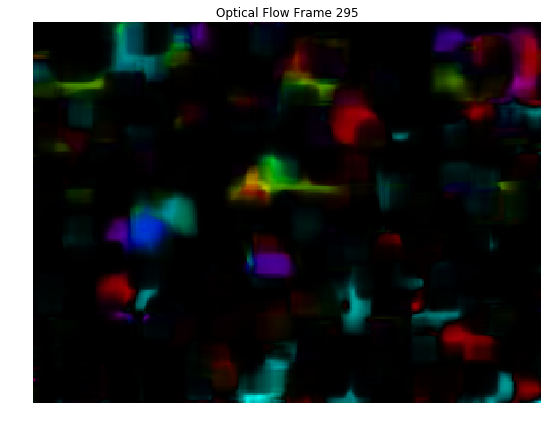

In [ ]:
input_path = 'train_set/train_set/v_Punch_g05_c01.avi'  # Update with your video path
output_path = 'Punch.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Rock Climbing Indoor:

Processing complete! Video saved to: /kaggle/working/RockClimbing.avi


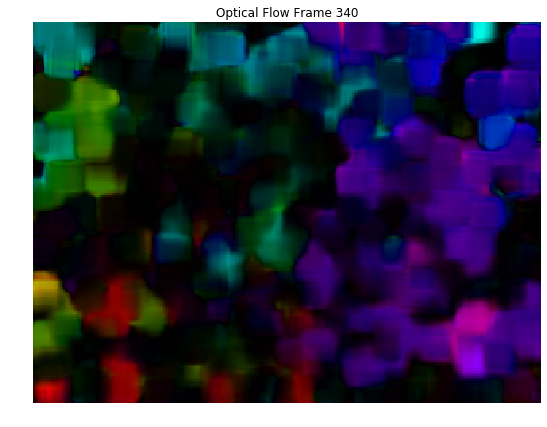

In [ ]:
input_path = 'train_set/train_set/v_RockClimbingIndoor_g03_c01.avi'  # Update with your video path
output_path = 'RockClimbing.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Soccer Juggling:

Processing complete! Video saved to: /kaggle/working/SoccerJuggling.avi


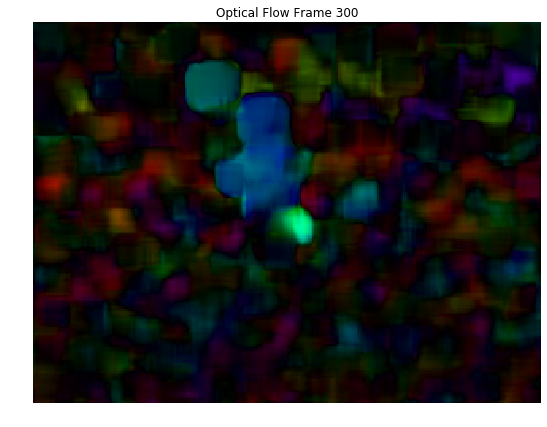

In [ ]:
input_path = 'train_set/train_set/v_SoccerJuggling_g07_c01.avi'  # Update with your video path
output_path = 'SoccerJuggling.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

Tennis Swing:

Processing complete! Video saved to: /kaggle/working/TennisSwing.avi


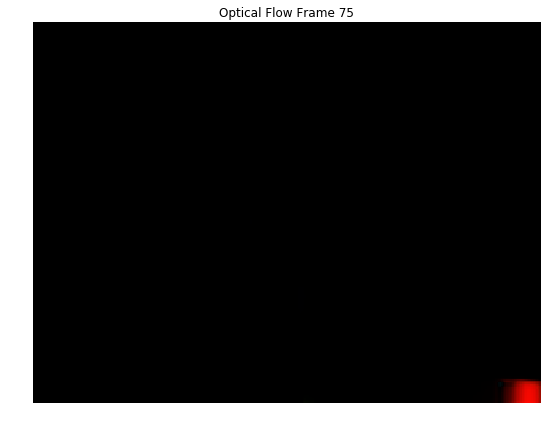

In [ ]:
input_path = 'train_set/train_set/v_TennisSwing_g01_c01.avi'  # Update with your video path
output_path = 'TennisSwing.avi'

cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise ValueError("Could not create output video")

ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(12, 7))
plt.axis('off')
frame_count = 0
display_interval = 5  

while cap.isOpened():
    ret, next_frame = cap.read()
    if not ret:
        break
    
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, next_gray, None,
        pyr_scale=0.5, levels=3, winsize=15,
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(prev_frame)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue (direction)
    hsv[..., 1] = 255  # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Save to video file
    out.write(flow_bgr)
    
    frame_count += 1
    if frame_count % display_interval == 0:
        flow_rgb = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
        ax.imshow(flow_rgb)
        ax.set_title(f"Optical Flow Frame {frame_count}")
        display(fig)
        clear_output(wait=True)  
    
    prev_gray = next_gray

cap.release()
out.release()
# plt.close()
cv2.destroyAllWindows()

print(f"Processing complete! Video saved to: {output_path}")

### Feature Histograms and Box Plots:

In [ ]:
dataset_path = "FeaturesNC.csv"
df = pd.read_csv(dataset_path, index_col='video_id')
df['label'] = df.index.map(lambda vid: vid[2:-12])

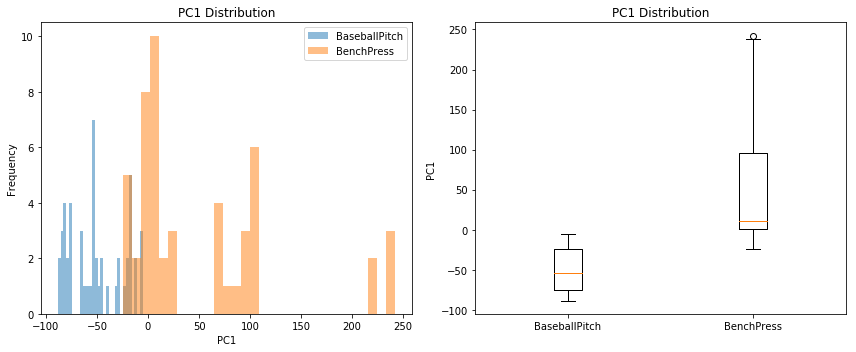

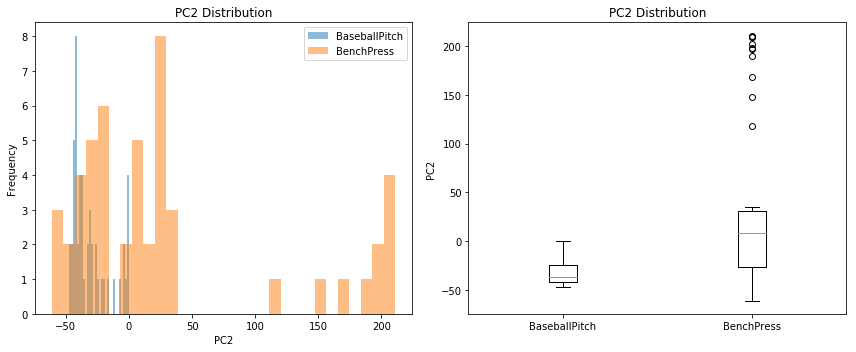

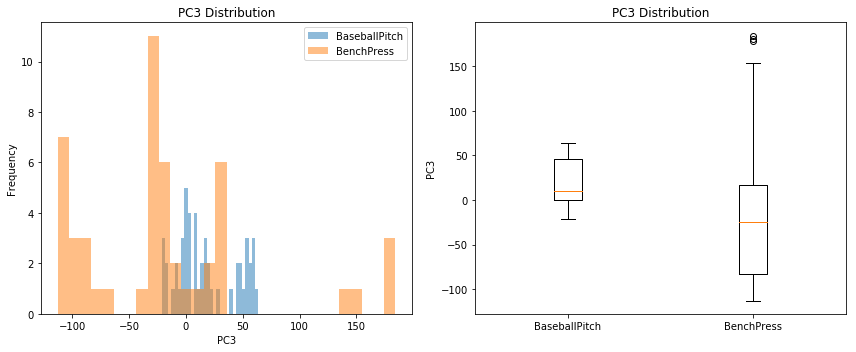

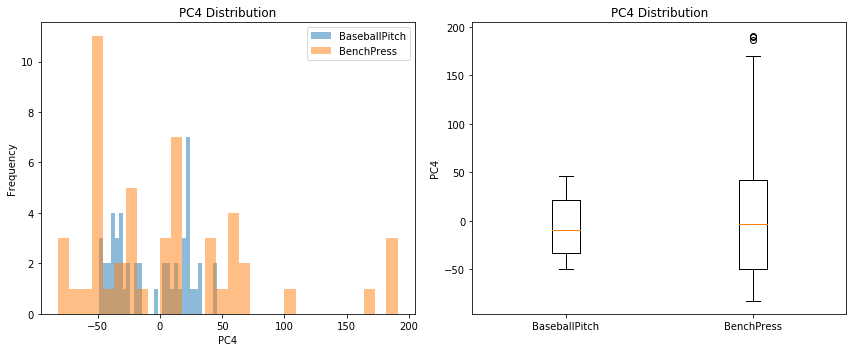

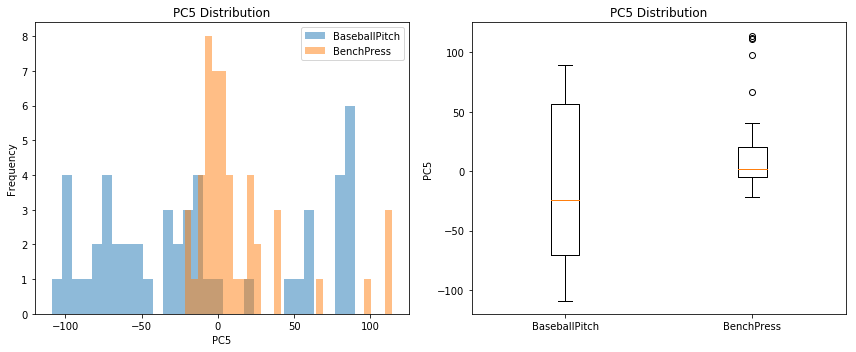

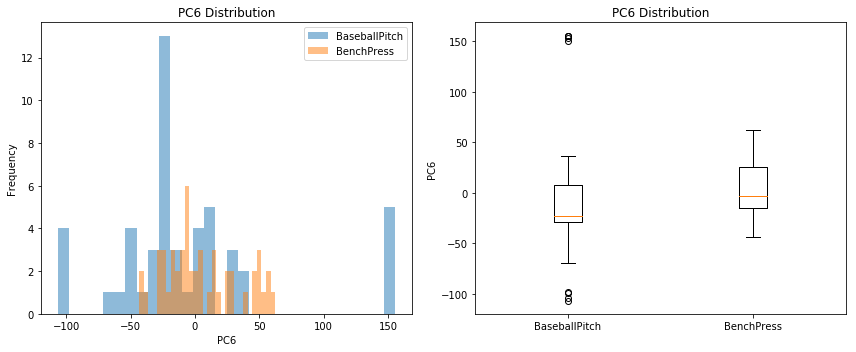

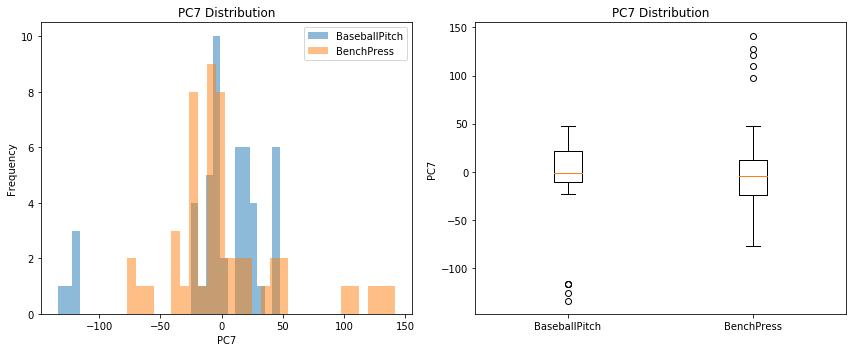

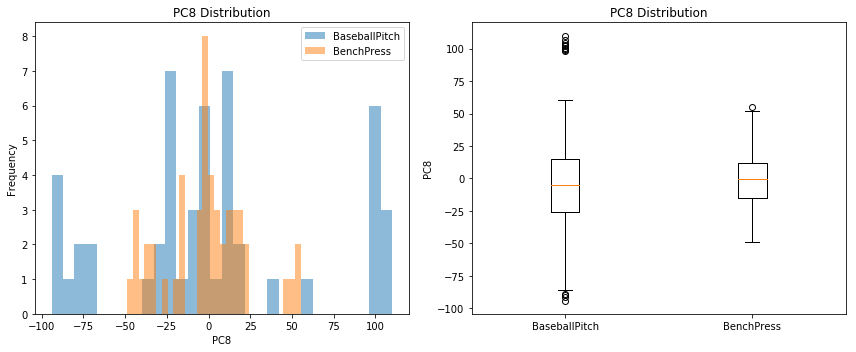

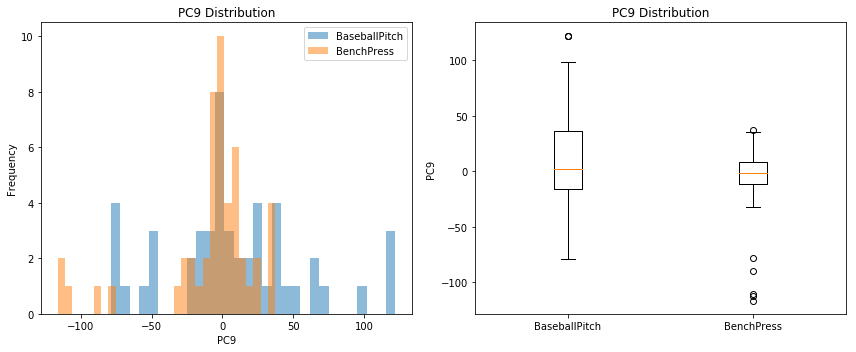

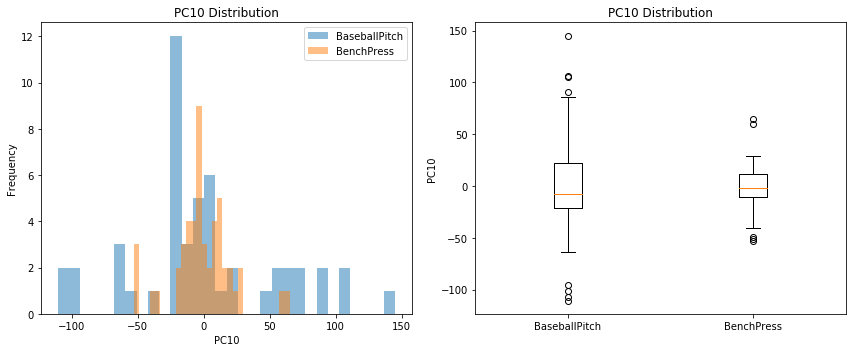

In [ ]:

%matplotlib inline

# Create directory for saving plots
os.makedirs('eda_plots', exist_ok=True)

# Load data and prepare features
# Assuming df_complete has columns: 'video_id', 'label', and feature columns
X = df.drop(['label'], axis=1)
y = df['label']

# Filter for our two classes
selected_classes = ["BaseballPitch", "BenchPress"]
mask = y.isin(selected_classes)
X_filtered = X[mask]
y_filtered = y[mask].reset_index(drop=True)

# Standardize and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame with PCA components and labels
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])
pca_df['label'] = y_filtered

# 1. Plot distributions for top 10 PCA components
for pc in pca_df.columns[:-1]:  # Exclude label column
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    for cls in selected_classes:
        cls_data = pca_df[pca_df['label'] == cls][pc]
        plt.hist(cls_data, bins=30, alpha=0.5, label=cls)
    plt.xlabel(pc)
    plt.ylabel('Frequency')
    plt.title(f'{pc} Distribution')
    plt.legend()
    
    # Box plot
    plt.subplot(1, 2, 2)
    box_data = [pca_df[pca_df['label'] == cls][pc] for cls in selected_classes]
    plt.boxplot(box_data, labels=selected_classes)
    plt.ylabel(pc)
    plt.title(f'{pc} Distribution')
    
    plt.tight_layout()
    plt.savefig(f'eda_plots/{pc}_distributions.png', dpi=100)
    plt.show()  # Display in notebook
    plt.close()

# 2. Perform ANOVA tests and display results


### Anova Test:

In [ ]:
anova_results = []
for pc in pca_df.columns[:-1]:
    groups = [pca_df[pca_df['label'] == cls][pc].values for cls in selected_classes]
    f_stat, p_val = f_oneway(*groups)
    anova_results.append({
        'Component': pc,
        'F-statistic': f_stat,
        'p-value': p_val
    })

anova_df = pd.DataFrame(anova_results)
print("\nANOVA Results:")
display(anova_df.style.format({'F-statistic': '{:.2f}', 'p-value': '{:.4f}'}))

# Save ANOVA results
anova_df.to_csv('eda_plots/anova_results.csv', index=False)

# 3. Document observations
significant_components = anova_df[anova_df['p-value'] < 0.05]['Component'].tolist()
top_component = anova_df.loc[anova_df['F-statistic'].idxmax()]

print("\nKey Observations:")
print(f"- Top discriminating component: {top_component['Component']} (F={top_component['F-statistic']:.1f}, p={top_component['p-value']:.4f})")
print(f"- Significant components at α=0.05: {len(significant_components)} out of 10")


ANOVA Results:


,Component,F-statistic,p-value
0,PC1,82.43,0.0000
1,PC2,26.06,0.0000
2,PC3,9.31,0.0029
3,PC4,1.76,0.1883
4,PC5,6.41,0.0129
5,PC6,1.21,0.2743
6,PC7,0.83,0.3637
7,PC8,0.10,0.7518
8,PC9,4.21,0.0429
9,PC10,0.03,0.8646



Key Observations:
- Top discriminating component: PC1 (F=82.4, p=0.0000)
- Significant components at α=0.05: 5 out of 10


## Dimensionality Reduction:

### Plotting Number of Components vs Explained Variance:

In [74]:
dataset_path = "/kaggle/input/featuresnc/FeaturesNC.csv"
df = pd.read_csv(dataset_path, index_col='video_id')
df['label'] = df.index.map(lambda vid: vid[2:-12])


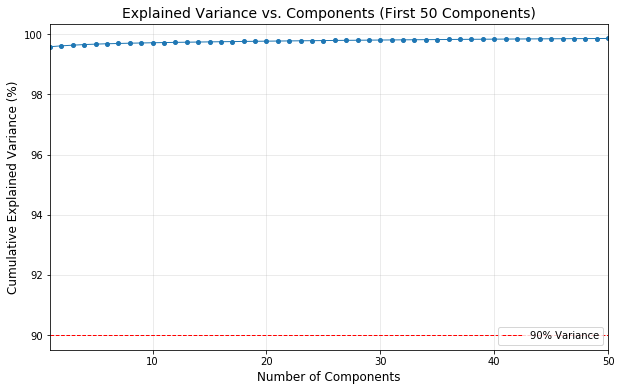

In [ ]:
features = df.drop(["label"], axis=1).values 

pca = PCA(n_components=min(50, features.shape[1])).fit(features)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1),  
         cumulative_variance, 
         marker='o', 
         markersize=4,
         linestyle='-',
         linewidth=1)

plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance (%)', fontsize=12)
plt.title(f'Explained Variance vs. Components (First {len(cumulative_variance)} Components)', fontsize=14)

plt.axhline(y=90, color='r', linestyle='--', linewidth=1, label='90% Variance')
plt.legend(loc='lower right')

plt.xlim(1, min(50, len(cumulative_variance)))

plt.grid(True, alpha=0.3)

plt.savefig('explained_variance_plot.png', 
            dpi=100,
            bbox_inches='tight')
plt.show()

## Model Tuning and Training:
### K-Means, Spectral and Agglomerative
Note: We are also tuning how many components we take from PCA along with the hyperparameters of the models  
As we see below, using all features gave a very low ARI. So we also ran all models without using MBH features, since MBH added a lot of noise. This showed a lot of improvement in the ARI.

#### Using All Features: 

In [77]:
true_labels = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(features, true_labels, test_size=0.4, random_state=42, stratify=true_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

n_clusters = 15

pca_variance_grid = [1, 2, 5, 10, 25, 50]

kmeans_n_init_grid = [10, 20, 30]

spectral_affinity_grid = ['nearest_neighbors', 'rbf']

agglo_linkage_grid = ['ward', 'average', 'complete']

def assign_labels_by_centroid(X_train, train_labels, X_val):
    unique_labels = np.unique(train_labels)
    centroids = []
    for label in unique_labels:
        centroid = X_train[train_labels == label].mean(axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    
    assigned = []
    for x in X_val:
        dists = np.linalg.norm(centroids - x, axis=1)
        assigned.append(unique_labels[np.argmin(dists)])
    return np.array(assigned)


def tune_clustering(method, param_grid, X_train, X_val, y_val, var_thresholds):
    best_ari = -1
    best_params = {}
    best_model = None  
    
    for var in tqdm(var_thresholds, desc=method):
        if method == 'spectral' and var < 5:  
            continue
            
        pca = PCA(n_components=var, random_state=42)
        try:
            X_train_pca = pca.fit_transform(X_train)
            X_val_pca = pca.transform(X_val)
        except LinAlgError:
            continue  

        for param in param_grid:
            try:
                if method == 'kmeans':
                    clustering = KMeans(n_clusters=n_clusters, n_init=param, random_state=42)
                elif method == 'spectral':
                    clustering = SpectralClustering(
                        n_clusters=n_clusters,
                        affinity=param,
                        random_state=42,
                        eigen_solver='arpack',  
                        n_neighbors=10 if param == 'nearest_neighbors' else None,  
                        gamma=1.0/(X_train_pca.shape[1]*X_train_pca.var())  
                    )
                elif method == 'agglo':
                    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=param)

                
                if method == 'kmeans':
                    clustering.fit(X_train_pca)
                    train_labels = clustering.predict(X_train_pca)
                    val_pred = clustering.predict(X_val_pca)
                else:
                    train_labels = clustering.fit_predict(X_train_pca)
                    val_pred = assign_labels_by_centroid(X_train_pca, train_labels, X_val_pca)
                
                ari = adjusted_rand_score(y_val, val_pred)
                train_ari = adjusted_rand_score(y_train, train_labels)
                
                if ari > best_ari:
                    best_ari = ari
                    best_params = {'n_components': var, 'clustering_param': param}
                    best_model = (pca, clustering, method)

            except (LinAlgError, ValueError) as e:
                print(f"Skipping {param} with {var} components due to error: {str(e)}")
                continue
    
    return best_ari, best_params, best_model

print("Tuning K-Means...")
ari_kmeans, params_kmeans, model_kmeans = tune_clustering('kmeans', kmeans_n_init_grid, X_train, X_val, y_val, pca_variance_grid)
print("Best K-Means ARI on validation:", ari_kmeans, "with parameters:", params_kmeans)

print("\nTuning Spectral Clustering...")
ari_spectral, params_spectral, model_spectral = tune_clustering('spectral', spectral_affinity_grid, X_train, X_val, y_val, pca_variance_grid)
print("Best Spectral Clustering ARI on validation:", ari_spectral, "with parameters:", params_spectral)

print("\nTuning Agglomerative Clustering...")
ari_agglo, params_agglo, model_agglo = tune_clustering('agglo', agglo_linkage_grid, X_train, X_val, y_val, pca_variance_grid)
print("Best Agglomerative Clustering ARI on validation:", ari_agglo, "with parameters:", params_agglo)





kmeans:   0%|          | 0/6 [00:00<?, ?it/s]

Tuning K-Means...





kmeans:  17%|█▋        | 1/6 [00:01<00:09,  1.81s/it]


kmeans:  33%|███▎      | 2/6 [00:03<00:07,  1.81s/it]


kmeans:  50%|█████     | 3/6 [00:05<00:05,  1.84s/it]


kmeans:  67%|██████▋   | 4/6 [00:07<00:03,  1.86s/it]


kmeans:  83%|████████▎ | 5/6 [00:10<00:02,  2.07s/it]


kmeans: 100%|██████████| 6/6 [00:12<00:00,  2.21s/it]


spectral:   0%|          | 0/6 [00:00<?, ?it/s]

Best K-Means ARI on validation: 0.013417558555103985 with parameters: {'n_components': 2, 'clustering_param': 10}

Tuning Spectral Clustering...





spectral:  50%|█████     | 3/6 [00:01<00:01,  1.50it/s]


spectral:  67%|██████▋   | 4/6 [00:03<00:01,  1.04it/s]


spectral:  83%|████████▎ | 5/6 [00:05<00:01,  1.35s/it]


spectral: 100%|██████████| 6/6 [00:08<00:00,  1.59s/it]


agglo:   0%|          | 0/6 [00:00<?, ?it/s]

Best Spectral Clustering ARI on validation: 0.018927293867443153 with parameters: {'n_components': 25, 'clustering_param': 'rbf'}

Tuning Agglomerative Clustering...





agglo:  17%|█▋        | 1/6 [00:01<00:06,  1.25s/it]


agglo:  33%|███▎      | 2/6 [00:02<00:04,  1.23s/it]


agglo:  50%|█████     | 3/6 [00:03<00:03,  1.28s/it]


agglo:  67%|██████▋   | 4/6 [00:05<00:02,  1.32s/it]


agglo:  83%|████████▎ | 5/6 [00:07<00:01,  1.54s/it]


agglo: 100%|██████████| 6/6 [00:09<00:00,  1.67s/it]

Best Agglomerative Clustering ARI on validation: 0.010727508623144833 with parameters: {'n_components': 50, 'clustering_param': 'complete'}


#### Without using MBH features:

In [68]:
df_2.set_index('video_id', inplace=True)
df_2['label'] = df_complete.index.map(lambda vid: vid[2:-12])
features = df_2.drop(["label"], axis=1).values 

In [69]:
true_labels = df_2['label'].values

X_train2, X_temp, y_train2, y_temp = train_test_split(features, true_labels, test_size=0.4, random_state=42, stratify=true_labels)
X_val2, X_test, y_val2, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

n_clusters = 15

pca_variance_grid = [1, 2, 5, 10, 25, 50]

kmeans_n_init_grid = [10, 20, 30]

spectral_affinity_grid = ['nearest_neighbors', 'rbf']

agglo_linkage_grid = ['ward', 'average', 'complete']

def assign_labels_by_centroid(X_train, train_labels, X_val):
    unique_labels = np.unique(train_labels)
    centroids = []
    for label in unique_labels:
        centroid = X_train[train_labels == label].mean(axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    
    assigned = []
    for x in X_val:
        dists = np.linalg.norm(centroids - x, axis=1)
        assigned.append(unique_labels[np.argmin(dists)])
    return np.array(assigned)


def tune_clustering(method, param_grid, X_train, X_val, y_val, var_thresholds):
    best_ari = -1
    best_params = {}
    best_model = None  
    
    for var in tqdm(var_thresholds, desc=method):
        pca = PCA(n_components=var, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        for param in param_grid:
            if method == 'kmeans':
                clustering = KMeans(n_clusters=n_clusters, n_init=param, random_state=42)
            elif method == 'spectral':
                clustering = SpectralClustering(n_clusters=n_clusters, affinity=param,
                                                random_state=42, assign_labels='discretize')
            elif method == 'agglo':
                clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=param)
            else:
                raise ValueError("Unknown clustering method")
            
            if method == 'kmeans':
                clustering.fit(X_train_pca)
                train_labels = clustering.predict(X_train_pca)
                val_pred = clustering.predict(X_val_pca)
            else:
                train_labels = clustering.fit_predict(X_train_pca)
                val_pred = assign_labels_by_centroid(X_train_pca, train_labels, X_val_pca)
            
            ari = adjusted_rand_score(y_val, val_pred)
            train_ari = adjusted_rand_score(y_train, train_labels)
            print(param, '--', "ari_train:", train_ari, '--', "ari_val: ", ari)

            
            if ari > best_ari:
                best_ari = ari
                best_params = {'n_components': var, 'clustering_param': param}
                best_model = (pca, clustering, method)
    
    return best_ari, best_params, best_model

print("Tuning K-Means...")
ari_kmeans2, params_kmeans2, model_kmeans2 = tune_clustering('kmeans', kmeans_n_init_grid, X_train2, X_val2, y_val2, pca_variance_grid)
print("Best K-Means ARI on validation:", ari_kmeans, "with parameters:", params_kmeans)

print("\nTuning Spectral Clustering...")
ari_spectral2, params_spectral2, model_spectral2 = tune_clustering('spectral', spectral_affinity_grid, X_train2, X_val2, y_val2, pca_variance_grid)
print("Best Spectral Clustering ARI on validation:", ari_spectral, "with parameters:", params_spectral)

print("\nTuning Agglomerative Clustering...")
ari_agglo2, params_agglo2, model_agglo2 = tune_clustering('agglo', agglo_linkage_grid, X_train2, X_val2, y_val2, pca_variance_grid)
print("Best Agglomerative Clustering ARI on validation:", ari_agglo, "with parameters:", params_agglo)




kmeans:   0%|          | 0/6 [00:00<?, ?it/s]

Tuning K-Means...
10 -- ari_train: 0.10432517782266992 -- ari_val:  0.08561737207391544
20 -- ari_train: 0.10432517782266992 -- ari_val:  0.08561737207391544




kmeans:  17%|█▋        | 1/6 [00:00<00:04,  1.11it/s]

30 -- ari_train: 0.10151313567603326 -- ari_val:  0.08906033107295881
10 -- ari_train: 0.14394402562349762 -- ari_val:  0.12360267140302049
20 -- ari_train: 0.14394402562349762 -- ari_val:  0.12360267140302049




kmeans:  33%|███▎      | 2/6 [00:01<00:03,  1.09it/s]

30 -- ari_train: 0.14394402562349762 -- ari_val:  0.12360267140302049
10 -- ari_train: 0.1995343361198192 -- ari_val:  0.20752086435261577
20 -- ari_train: 0.21199509948750445 -- ari_val:  0.19133373482656876




kmeans:  50%|█████     | 3/6 [00:02<00:02,  1.05it/s]

30 -- ari_train: 0.21199509948750445 -- ari_val:  0.19133373482656876
10 -- ari_train: 0.1802859407109607 -- ari_val:  0.18087615317860165
20 -- ari_train: 0.1802859407109607 -- ari_val:  0.18087615317860165




kmeans:  67%|██████▋   | 4/6 [00:03<00:01,  1.02it/s]

30 -- ari_train: 0.1802859407109607 -- ari_val:  0.18087615317860165
10 -- ari_train: 0.16028523767793776 -- ari_val:  0.13960716266723258
20 -- ari_train: 0.16028523767793776 -- ari_val:  0.13960716266723258




kmeans:  83%|████████▎ | 5/6 [00:05<00:01,  1.07s/it]

30 -- ari_train: 0.16028523767793776 -- ari_val:  0.13960716266723258
10 -- ari_train: 0.1778578777651579 -- ari_val:  0.1364254033509688
20 -- ari_train: 0.1778578777651579 -- ari_val:  0.1364254033509688




kmeans: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

spectral:   0%|          | 0/6 [00:00<?, ?it/s]

30 -- ari_train: 0.1778578777651579 -- ari_val:  0.1364254033509688
Best K-Means ARI on validation: 0.20752086435261577 with parameters: {'n_components': 5, 'clustering_param': 10}

Tuning Spectral Clustering...




spectral:  17%|█▋        | 1/6 [00:00<00:02,  1.87it/s]

nearest_neighbors -- ari_train: 0.1156034628704765 -- ari_val:  0.0941710583608981
rbf -- ari_train: 0.1035621585234782 -- ari_val:  0.08357032478709481




spectral:  33%|███▎      | 2/6 [00:01<00:02,  1.90it/s]

nearest_neighbors -- ari_train: 0.1435143073633112 -- ari_val:  0.13021389094756394
rbf -- ari_train: 0.10850812210688585 -- ari_val:  0.11400943188983416
nearest_neighbors -- ari_train: 0.23538965893107655 -- ari_val:  0.20331236146867301




spectral:  50%|█████     | 3/6 [00:01<00:01,  1.62it/s]

rbf -- ari_train: 0.012880256787653407 -- ari_val:  0.029986956715375275
nearest_neighbors -- ari_train: 0.18809887248738894 -- ari_val:  0.18080613028391856




spectral:  67%|██████▋   | 4/6 [00:15<00:08,  4.48s/it]

rbf -- ari_train: 0.00015044353813148598 -- ari_val:  0.004729837595219162
nearest_neighbors -- ari_train: 0.17392807615655462 -- ari_val:  0.16083070869615085




spectral:  83%|████████▎ | 5/6 [00:26<00:06,  6.53s/it]

rbf -- ari_train: 0.002497116666262557 -- ari_val:  0.048559217923572415
nearest_neighbors -- ari_train: 0.16166439521089976 -- ari_val:  0.14062643642969075




spectral: 100%|██████████| 6/6 [00:36<00:00,  7.56s/it]

agglo:   0%|          | 0/6 [00:00<?, ?it/s]

rbf -- ari_train: 0.03330641048762429 -- ari_val:  0.07514018255417124
Best Spectral Clustering ARI on validation: 0.20331236146867301 with parameters: {'n_components': 5, 'clustering_param': 'nearest_neighbors'}

Tuning Agglomerative Clustering...




agglo:  17%|█▋        | 1/6 [00:00<00:02,  2.00it/s]

ward -- ari_train: 0.10340260056318566 -- ari_val:  0.09068521140075342
average -- ari_train: 0.09460119393402691 -- ari_val:  0.10536957021304393
complete -- ari_train: 0.0995460437969405 -- ari_val:  0.08661463701461433




agglo:  33%|███▎      | 2/6 [00:00<00:01,  2.05it/s]

ward -- ari_train: 0.13076112760839464 -- ari_val:  0.12280813748851896
average -- ari_train: 0.09820982682469433 -- ari_val:  0.0908127604113942
complete -- ari_train: 0.11249879782416382 -- ari_val:  0.11461733475654179




agglo:  50%|█████     | 3/6 [00:01<00:01,  1.99it/s]

ward -- ari_train: 0.2094028256804427 -- ari_val:  0.18490795095355705
average -- ari_train: 0.12798588158457624 -- ari_val:  0.11851614619606567
complete -- ari_train: 0.14885676207650847 -- ari_val:  0.1657059595572014




agglo:  67%|██████▋   | 4/6 [00:02<00:01,  1.94it/s]

ward -- ari_train: 0.20194110053635048 -- ari_val:  0.16777506157793143
average -- ari_train: 0.05021729058937725 -- ari_val:  0.05199395151276873
complete -- ari_train: 0.1662589090630432 -- ari_val:  0.1456106087964455




agglo:  83%|████████▎ | 5/6 [00:02<00:00,  1.71it/s]

ward -- ari_train: 0.1946947545471001 -- ari_val:  0.16225521215103883
average -- ari_train: 0.008840721917667965 -- ari_val:  0.007641885696870728
complete -- ari_train: 0.062153965505601726 -- ari_val:  0.06693646098842249




agglo: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

ward -- ari_train: 0.1568301490803278 -- ari_val:  0.13747910270439037
average -- ari_train: 0.008312101354121717 -- ari_val:  0.009280285657895314
complete -- ari_train: 0.07400632368496345 -- ari_val:  0.07274292027400835
Best Agglomerative Clustering ARI on validation: 0.18490795095355705 with parameters: {'n_components': 5, 'clustering_param': 'ward'}


## Model Testing and Comparison:

#### Using all features:

In [82]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

def evaluate_on_test(best_model, X_train_val, X_test, y_test):
    best_pca, best_clusterer, method = best_model
    # Refit PCA on training+validation.
    pca = PCA(n_components=best_pca.n_components_, random_state=42)
    X_train_val_pca = pca.fit_transform(X_train_val)
    X_test_pca = pca.transform(X_test)
    
    if method == 'kmeans':
        best_clusterer.fit(X_train_val_pca)
        test_pred = best_clusterer.predict(X_test_pca)
    else:
        train_labels = best_clusterer.fit_predict(X_train_val_pca)
        test_pred = assign_labels_by_centroid(X_train_val_pca, train_labels, X_test_pca)
    
    return adjusted_rand_score(y_test, test_pred)

ari_test_kmeans = evaluate_on_test(model_kmeans, X_train_val, X_test, y_test)
ari_test_spectral = evaluate_on_test(model_spectral, X_train_val, X_test, y_test)
ari_test_agglo = evaluate_on_test(model_agglo, X_train_val, X_test, y_test)

print("\nTest ARI Scores:")
print("K-Means Test ARI:", ari_test_kmeans)
print("Spectral Clustering Test ARI:", ari_test_spectral)
print("Agglomerative Clustering Test ARI:", ari_test_agglo)


Test ARI Scores:
K-Means Test ARI: -0.006303302350460323
Spectral Clustering Test ARI: 0.005526198069924447
Agglomerative Clustering Test ARI: 0.004026204554773629


#### Without using MBH features:

In [70]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

def evaluate_on_test(best_model, X_train_val, X_test, y_test):
    best_pca, best_clusterer, method = best_model
    # Refit PCA on training+validation.
    pca = PCA(n_components=best_pca.n_components_, random_state=42)
    X_train_val_pca = pca.fit_transform(X_train_val)
    X_test_pca = pca.transform(X_test)
    
    if method == 'kmeans':
        best_clusterer.fit(X_train_val_pca)
        test_pred = best_clusterer.predict(X_test_pca)
    else:
        train_labels = best_clusterer.fit_predict(X_train_val_pca)
        test_pred = assign_labels_by_centroid(X_train_val_pca, train_labels, X_test_pca)
    
    return adjusted_rand_score(y_test, test_pred)

ari_test_kmeans = evaluate_on_test(model_kmeans2, X_train_val, X_test, y_test)
ari_test_spectral = evaluate_on_test(model_spectral2, X_train_val, X_test, y_test)
ari_test_agglo = evaluate_on_test(model_agglo2, X_train_val, X_test, y_test)

print("\nTest ARI Scores:")
print("K-Means Test ARI:", ari_test_kmeans)
print("Spectral Clustering Test ARI:", ari_test_spectral)
print("Agglomerative Clustering Test ARI:", ari_test_agglo)


Test ARI Scores:
K-Means Test ARI: 0.20130368651680525
Spectral Clustering Test ARI: 0.18309344924496423
Agglomerative Clustering Test ARI: 0.1882215055813703


## Dendogram for Agglomerative Clustering:

Using all features:

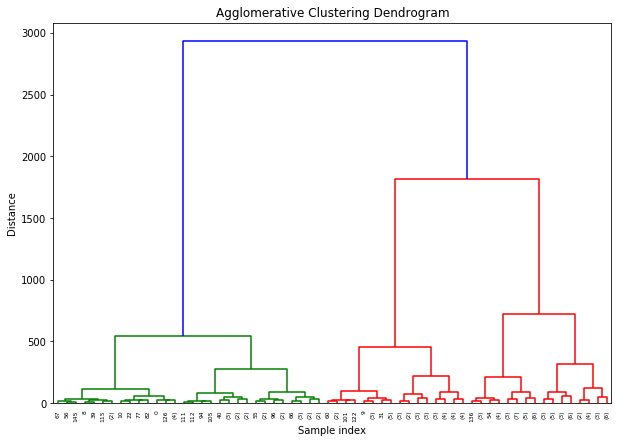

In [ ]:
best_pca_agglo, _, _ = model_agglo
pca_for_dendro = PCA(n_components=best_pca_agglo.n_components_, random_state=42)
X_test_pca_agglo = pca_for_dendro.fit_transform(X_test)

Z = linkage(X_test_pca_agglo, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Agglomerative Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.savefig('dendogram.png', 
            dpi=100,
            bbox_inches='tight')
plt.show()

#### Without using MBH:

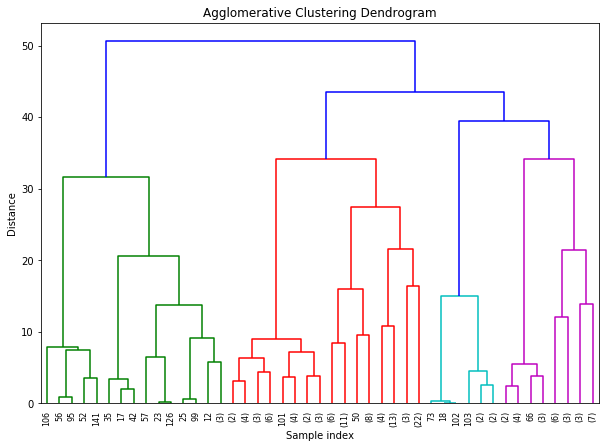

In [ ]:
best_pca_agglo, _, _ = model_agglo2
pca_for_dendro = PCA(n_components=best_pca_agglo.n_components_, random_state=42)
X_test_pca_agglo = pca_for_dendro.fit_transform(X_test)

Z = linkage(X_test_pca_agglo, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Agglomerative Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.savefig('dendogram_wo_mbh.png', 
            dpi=100,
            bbox_inches='tight')
plt.show()